In [168]:
#default_exp dr

In [169]:
#hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dimensionality reduction

> This notebook gets the embeddings (or latent space) from a multivariate time series 
given by a encoder (e.g., autoencoder) and uses them as input for a 
dimensionality reduction algorithm, to generate projectsion of the embeddings

In [170]:
#export
import umap
import pandas as pd
import numpy as np
from fastcore.all import *
from tchub.all import *

In [171]:
#hide
import matplotlib.pyplot as plt
import wandb
api = wandb.Api()
from yaml import load, FullLoader
import hdbscan
from tsai.all import *

## Config parameters

Put here everything that could be needed if this notebook

In [172]:
config = AttrDict(
    use_wandb = True, # Whether to use or not wandb for experiment tracking
    wandb_group = None, # Whether to group this run in a wandb group
    wandb_entity = 'vrodriguezf90',
    wandb_project = 'tchub',
    dr_artifact_name = 'tchub/taxi:v4', # * Set to None for using the default one (encoder validation set)
    enc_artifact = 'tchub/learner-mvp:run-tchub-3tipekxw', # Name:version of the encoder artifact
    enc_run_path= 'tchub/3tipekxw', # Path of the run that generate embeddings (deprecated?)
    n_neighbors = 15, #UMAP
    min_dist = 0.1, #UMAP
    metric = 'euclidean', #UMAP
    verbose = True # UMAP
)

This model needs to restore the encoder model fitted in the notebook `02x`, as well as the data and configuration

## Run

In [173]:
run_dr = wandb.init(entity=config.wandb_entity,
                    project=config.wandb_project if config.use_wandb else 'work-nbs', 
                    group=config.wandb_group,
                    allow_val_change=True, 
                    job_type='dimensionality_reduction', 
                    mode='online', # always online to use artifacts...I don't like this
                    anonymous = 'never' if config.use_wandb else 'must',
                    config=config,
                    resume=False)
config_dr = wandb.config # Object for storing hyperparameters

wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Restore the encoder model and its associated configuration

In [174]:
enc_learner = run_dr.use_artifact(config.enc_artifact).to_obj()

Restore the dataset artifact used for training the encoder. Even if we do not compute the dimensionality reduction over this dataset, we need to know the metadata of the encoder training set, to check that 
it matches with the dataset that we want to reduce.

In [175]:
# TODO: Correct order??
# 1 is the training artifact, 0 the validation
enc_run = api.run(config_dr.enc_run_path)
uas = enc_run.used_artifacts()
enc_artifact_train = uas[1] if len(uas) > 1 else uas[0] 
enc_artifact_valid = uas[0]
enc_artifact_train.name, enc_artifact_valid.name

('taxi:v4', 'taxi:v4')

Now we specify the dataset artifact that we want to use for the reduction. If no artifact is defined, the artifact to reduce will be the one used for validate the encoder.

In [176]:
if config_dr.dr_artifact_name is not None:
    dr_artifact = run_dr.use_artifact(config_dr.dr_artifact_name)
else:
    dr_artifact = run_dr.use_artifact(enc_artifact_valid)
dr_artifact.name

'taxi:v4'

Now we need to check whether the artifact that is going to be used fort the dimensionality reduction matches the artifact used to train the encoder. Matching means having the same number of variables, the same window size and stride, and the same frequency.

In [177]:
#export
def check_compatibility(dr_ar:TSArtifact, enc_ar:TSArtifact):
    "Function to check that the artifact used by the encoder model and the artifact that is \
    going to be passed through the DR are compatible"
    try:
        # Check that both artifacts have the same variables
        chk_vars = dr_ar.metadata['TS']['vars'] == enc_ar.metadata['TS']['vars']
        # Check that both artifacts have the same freq
        chk_freq = dr_ar.metadata['TS']['freq'] == enc_ar.metadata['TS']['freq']
        # Check that the dr artifact is not normalized (not normalized data has not the key normalization)
        chk_norm = dr_ar.metadata['TS'].get('normalization') is None
        # Check that the dr artifact has not missing values
        chk_miss = dr_ar.metadata['TS']['has_missing_values'] == "False"
        # Check all logical vars.
        if chk_vars and chk_freq and chk_norm and chk_miss:
            print("Artifacts are compatible.")
        else:
            raise Exception
    except Exception as e:
        print("Artifacts are not compatible.")
        raise e
    return None


In [178]:
df = dr_artifact.to_df()
df

,value
timestamp,
2014-10-01 00:00:00,12751
2014-10-01 00:30:00,8767
2014-10-01 01:00:00,7005
2014-10-01 01:30:00,5257
2014-10-01 02:00:00,4189
...,...
2014-12-14 21:30:00,16344
2014-12-14 22:00:00,15913
2014-12-14 22:30:00,14327


In [179]:
df.shape

(3600, 1)

In [180]:
enc_input, _ = SlidingWindow(window_len=enc_run.config['w'], 
                             stride=enc_run.config['stride'], 
                             get_y=[])(df)
enc_input.shape

(3553, 1, 48)

### Getting the embeddings (activations) from the encoder

Once the encoder model is trained, we are interested in the information contained in its backbone for each slice of data. To do that, we have to call the `predict` function on an intermediate model that gets the output of the intermediate layer.

#export dcae
from tensorflow.keras.models import Model
def get_latent_features(dcae, input_data, bottleneck_ln='latent_features'):
    "Get the activations of the bottleneck layer within the fitted autoencoder `dcae` (a Keras model) \
    for the input data `input_data` (a tensor). The name of the bottleneck layer is given in `bottleneck_ln"
    layer_latent_output = dcae.get_layer(bottleneck_ln).output
    intermediate_model = Model(inputs=dcae.input, outputs=layer_latent_output)
    intermediate_prediction = intermediate_model.predict(input_data)
    return intermediate_prediction

In [181]:
aux_dl = enc_learner.dls.valid.new_dl(X=enc_input)
aux_dl.bs = enc_learner.dls.bs if enc_learner.dls.bs>0 else 64
module = nested_attr(enc_learner.model, ENCODER_EMBS_MODULE_NAME[type(enc_learner.model)])
embs = [get_acts_and_grads(model=enc_learner.model, 
                          modules=module, 
                          x=xb[0], cpu=True)[0] for xb in aux_dl]
embs = to_concat(embs)
test_eq(embs.shape[0], enc_input.shape[0])
embs.shape, embs.device

(torch.Size([3553, 128, 48]), device(type='cpu'))

Average embeddings in the time dimension, if needed

In [182]:
if embs.ndim == 3: embs = embs.mean(axis=2)
embs.shape

torch.Size([3553, 128])

## Dimensionality reduction using UMAP

We use DR techniques to provide an alternative view for users to visually analyze and explore the time-series data. The algorithm UMAP shows its high competitiveness compared to t-SNE. t-SNE suffers from some limitations such as loss of large-scale information (the inter-cluster relationships). UMAP has a faster runtime and provides better scaling which helps to gain a meaningful organization of clusters, outliers and the preservation of continuums compared to t-SNE

For this part of the implementation, the package [umap-learn](https://github.com/lmcinnes/umap) is used. The input of the algoritm is the $n \times \delta$ that contains, for each slice of the time series, the corresponding $\delta$ latent embeddings given by the encoder.

The hyperparameters of UMAP are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [183]:
umap_params = {
    'n_neighbors' : config_dr.n_neighbors,
    'min_dist' : config_dr.min_dist,
    'metric' : config_dr.metric,
    'verbose': True
}

Finally, we gather all this functionality into a function for future use

In [185]:
#export
import warnings
from numba.core.errors import NumbaPerformanceWarning
@delegates(umap.umap_.UMAP)
def fget_UMAP_projections(input_data, **kwargs):
    "Compute the projections of `input_data` using UMAP, with a configuration contained in `**kwargs`. \
    Returns also information of the reducer."
    warnings.filterwarnings("ignore", category=NumbaPerformanceWarning) # silence NumbaPerformanceWarning
    reducer = umap.UMAP(**kwargs)
    reducer.fit(input_data)
    projections = reducer.transform(input_data)
    return (projections, reducer)

In [186]:
%%time
prjs, reducer = fget_UMAP_projections(embs, **umap_params)
prjs.shape

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Thu Oct  7 10:24:32 2021 Finding Nearest Neighbors
Thu Oct  7 10:24:32 2021 Finished Nearest Neighbor Search
Thu Oct  7 10:24:32 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Oct  7 10:24:43 2021 Finished embedding
CPU times: user 4min 52s, sys: 6.07 s, total: 4min 58s
Wall time: 17.3 s


(3553, 2)

In [187]:
test_eq(prjs.shape, (prjs.shape[0], reducer.n_components))

In [188]:
# Test if the reducer contains the items of the configuration object
test_eq(all(item in reducer.get_params().items() for item in dict(umap_params).items()), True)

Save the embeddings as an artifact

In [189]:
prjs_ar = ReferenceArtifact(obj=prjs, name='projections')
prjs_ar.metadata, prjs_ar.manifest.entries.values()

({'ref': {'hash': '-1059183167534114367', 'type': "<class 'numpy.ndarray'>"}},
 dict_values([<ManifestEntry ref: file:///home/victor/data/wandb_artifacts/-1059183167534114367/-1059183167534114367>]))

In [190]:
run_dr.log_artifact(prjs_ar)

# This should not be needed, it can be found in wandb.Api.run.logged_artifacts
config_dr.update(
    {
          'emb_artifact_type': embeddings_ar.type,
          'emb_artifact_name': embeddings_ar.name,
          'emb_artifact_digest': embeddings_ar.digest
    }, 
    allow_val_change=True)

## Create Precomputed Clusters

In order to integrate precomputed clusters into the embedding space, it's necessary to log artifacts that include the labels of the newly created clusters. 

The cluster creation process is presented below. This creation procedure can be modified according to specific needs. However, the structure of the new artifact must be preserved (it must be a numpy.ndarray and the number of elements must be equal to the number of points in the embedding space).

In [191]:
print(f'HDBSCAN supported metrics: {list(hdbscan.dist_metrics.METRIC_MAPPING.keys())}')

HDBSCAN supported metrics: ['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'cosine', 'arccos', 'pyfunc']


In [192]:
# Define HDBSCAN parameters
hdbscan_kwargs = {
    'min_cluster_size' : 100,
    'min_samples' : 15,
    'cluster_selection_epsilon' : 0.08,
}
metric_kwargs = {
    'metric' : 'jaccard'
}

In [193]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
clusters_labels = clusters.labels_
clusters_labels

array([-1, -1, -1, ..., -1, -1, -1])

In [194]:
# Testing artifact structure 
test_eq_type(type(clusters_labels), np.ndarray)
test_eq(clusters_labels.size, prjs.shape[0])

In [195]:
# Create and log 'clusters_labels' artifact
clusters_ar = ReferenceArtifact(obj=clusters_labels, name='clusters_labels')
clusters_ar.metadata, clusters_ar.manifest.entries.values()

({'ref': {'hash': '1268660098414917857', 'type': "<class 'numpy.ndarray'>"}},
 dict_values([<ManifestEntry ref: file:///home/victor/data/wandb_artifacts/1268660098414917857/1268660098414917857>]))

In [196]:
run_dr.log_artifact(clusters_ar, aliases=['hdbscan_jaccard'])

## 2D Visualization 

While the connected scatter plot is a simple visualization technique, it has very specific functions in our approach. Every sliding window is represented as a dot in the plot after the projection process (Fig. 4C, D of the paper). Before labeling, all points have the same color and transparency, and when they are concentrated in one area, the densities are accumulated. Lines are used to connect consecutive points preserving the temporal ordering of the data and allowing the user to see temporal connections (Fig. 4B of the paper). Thus, the point is linked to the previous point (inner) and to the posterior point (outer) as an indication of the flow of time.

In [197]:
#export
def plot_projections(prjs, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f} metric:{:s}'.format(
        umap_params['n_neighbors'],umap_params['min_dist'],umap_params['metric']))
    return ax

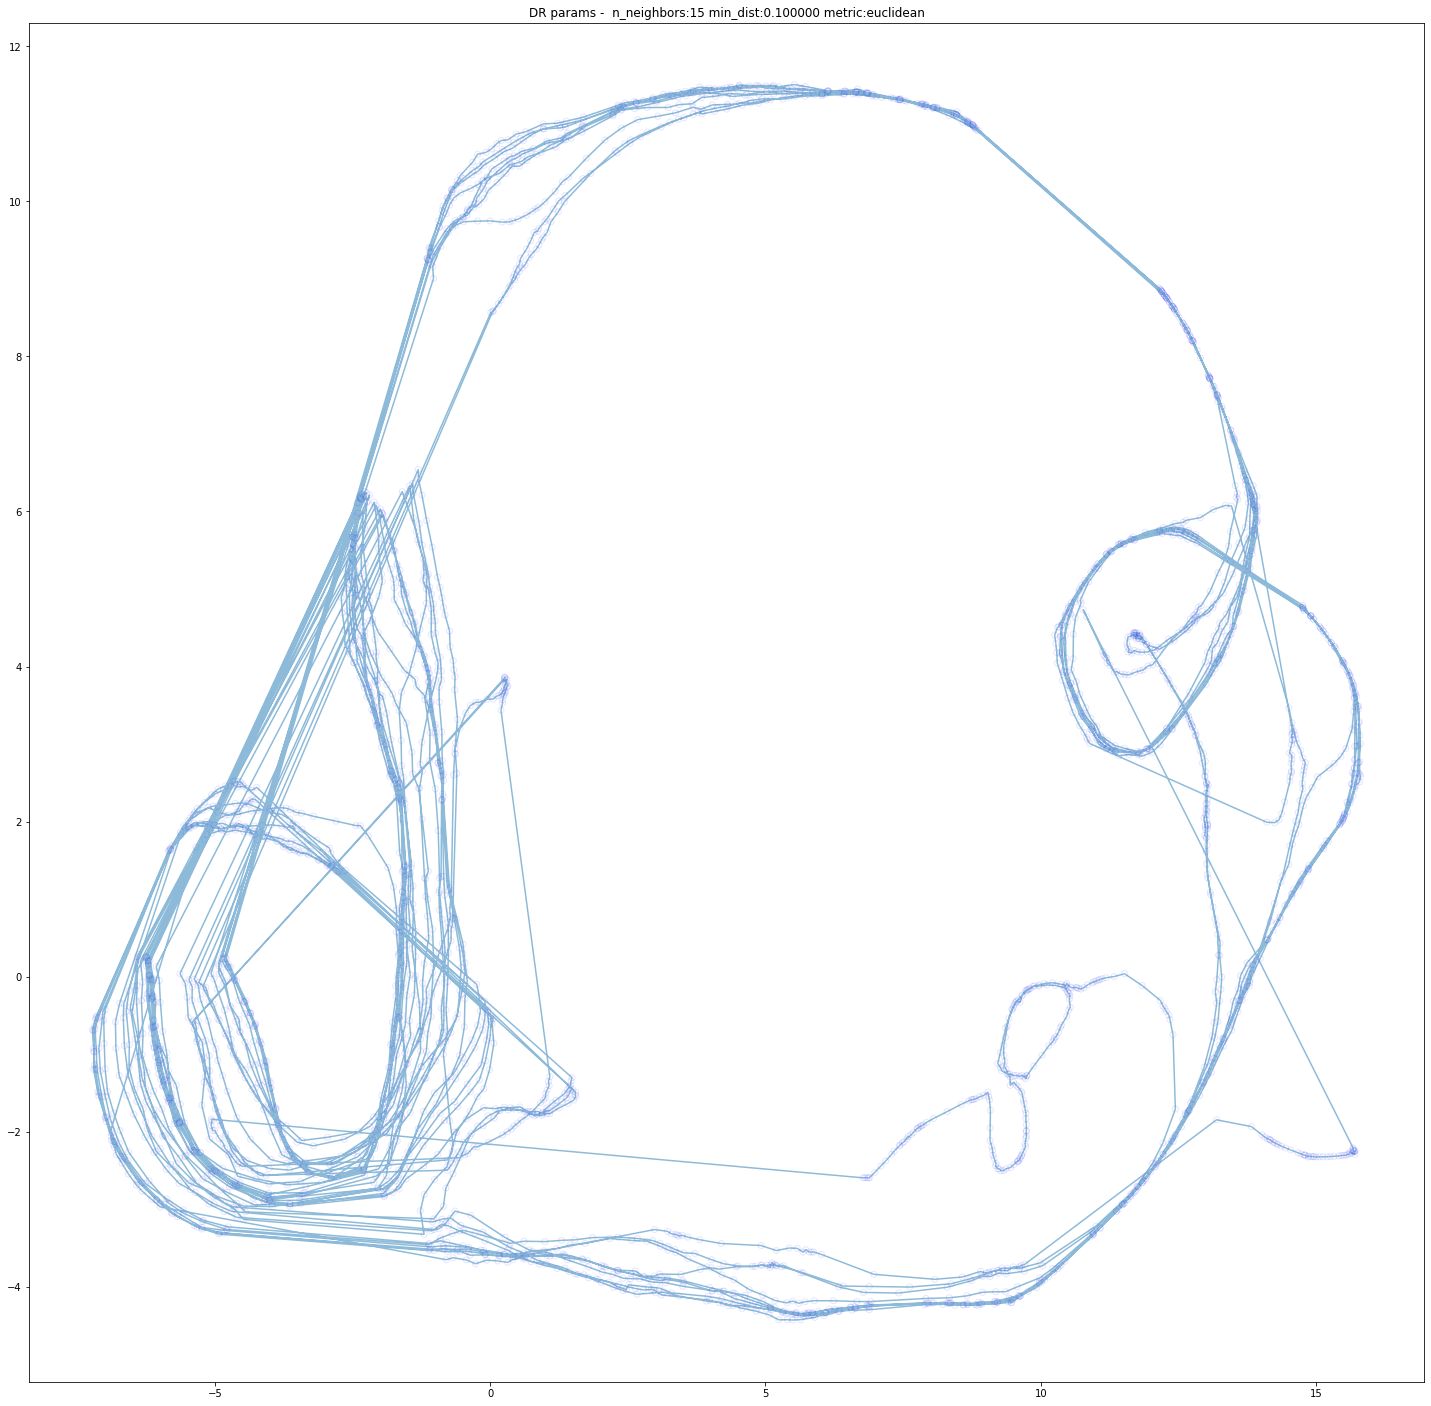

In [198]:
prjs_plt = plot_projections(prjs, umap_params)

Log this plot as part of the current wandb run

In [199]:
#hide

# Get the figure of the embedding plot, and save it on thea wandb run.
run_dr.log({"img": [wandb.Image(prjs_plt.get_figure(), caption="dr_projections_plot")]})

#run_dr.log({'embeddings_plot': embeddings_plot})

In [200]:
#hide
run_dr.finish()

# Explainability with SHAP (future work)

In [201]:
# %matplotlib inline

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111)

# ax.scatter(df_embeddings['x1'], df_embeddings['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
# ax.plot(df_embeddings['x1'], df_embeddings['x2'], alpha=0.5, picker=1)
# ax.set_title('Select the point you want to visualize as a time window in the original space')

Make the plot interactive to allow selection of subsets of the plot

In [202]:
# selected_indices = None
# selected_points = None

# def onpick(event):
#     global selected_points
#     thisline = event.artist
#     xdata = thisline.get_xdata()
#     ydata = thisline.get_ydata()
#     global selected_indices
#     selected_indices = event.ind
#     selected_points = tuple(zip(xdata[selected_indices], ydata[selected_indices]))
#     print('onpick points (first):', selected_points[0])

# fig.canvas.mpl_connect('pick_event', onpick)

# plt.show()
# fig.tight_layout()
# fig.savefig(f'../img/w={w}.png')

## Hyperparameter tuning for the dimensionality reduction

There are a number of parameters that can be set for the UMAP algorithm. The major 
ones are `n_neighbors` and `min_dist`. Thus, we will carry out a hyperparameter 
sweep in Weights and Biases for these two parameters. Note that there is no objective
way of deciding that some embeddings are better than others. Thus, we must rely on our
intuition by visualizing the 2D plots of each of the runs in the sweep.

The first thing we need is gather all the pipeline of the previous section into a function


## Linking back points of the 2D projection to the original time series

The variable `selected_points` and `ind` contain an array of the points and indices selected in the previous 2D projection. We will take the first of them (there can be many selected points with just one click), and use its index to get the corresponding time window of the original space.

In [203]:
# selected_window = input_data[df_embeddings.sample(n=1).index][0] if selected_indices is None else input_data[selected_indices[0]]
# selected_window

### Visualizing all the variables in the time window (default)

In [204]:
# %matplotlib inline
# g = sns.FacetGrid(df_output_tidy, col="variable", col_wrap=3, aspect=2)
# g = g.map(plt.plot, "timestamp", "value")

### Contribution: Visualize only the most relevant variables

In high dimensional time series, not only is interesting to see the window associated to a point in the 2D space, but also it is extremely important to spot which variables are mainly causing that the window is positioned in that point of the 2D space.

Since UMAP does not provide capabilities to understand feature importance, there are [different ways](https://stats.stackexchange.com/questions/438025/understand-important-features-in-umap) to tackle this problem:

1. Use another dimensionality reduction technique that provides importance, such as [sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html)

2. Create a surrogate model on top of the inputs/output of UMAP and explain it using XAI techniques. We will try here this option.

The idea is to have a surrogate model that takes the multivariate time series as input and produces the associated points in the 2D space as ouput. Since we already have a Deep Convolutional Autoencoder (DCAE) that takes a multivariate time series as input, and it contains the latent features that represent that input, we can use it for the surrogate. We will use the intermediate model that goes from the input to the layer containing the latent space, and then add a `Dense` layer with 2 units and linear activation.

In [205]:
#export
# def train_surrogate_model(dcae, embeddings, lat_ln='latent_features'):
#     "Train a surrogate model that learns the `embeddings` from the latent features contained in the layer \
#     `lat_ln` of a previously trained Deep Convolutional AutoEncoder `dcae`"
#     x = dcae.get_layer(lat_ln).output
#     x = Dense(units=embeddings.shape[1], activation='linear')(x)
#     surrogate_model = Model(dcae.input, x)
#     l_nms = [layer.name for layer in surrogate_model.layers]
#     layer_idx = l_nms.index(lat_ln)
#     # The layers that are already trained from the autoencoder must be `frozen`
#     for layer in surrogate_model.layers[:layer_idx]:
#         layer.trainable = False
#     return surrogate_model

In [206]:
# sm = train_surrogate_model(m, embeddings, lat_ln='latent_features')

In [207]:
# test.equals(sm.input.shape, m.input.shape)
# test.equals(sm.output.shape[1], embeddings.shape[1])
# l_nms = [layer.name for layer in sm.layers]
# layer_idx = l_nms.index('latent_features')
# test.all_equal([layer.trainable for layer in sm.layers], \
#                np.repeat([False, True], [layer_idx + 1, len(sm.layers) -1 -layer_idx]))

Configure the training hyperparameters

In [208]:
# loss = 'mean_squared_error'
# opt = 'adam'
# bs = 100
# epochs = 10
# val = .2

In [209]:
# sm.output_shape

In [210]:
# input_data.shape

In [211]:
# embeddings.shape

In [212]:
# sm.fit(x=input_data, y=embeddings, batch_size=bs, validation_split=val, epochs=epochs, callbacks=[WandbCallback()])

In [213]:
# import innvestigate

In [214]:
# analyzer = innvestigate.create_analyzer("gradient", intermediate_model)

In [215]:
# asd= innvestigate.create_analyzer("gradient", m)

In [216]:
# from keras.datasets import mnist

In [217]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [218]:
# x_train.shape

In [219]:
# input_data[np.random.choice(input_data.shape[0], 100, replace=False)].shape

In [220]:
# import shap

In [221]:
# background = input_data[np.random.choice(input_data.shape[0], 100, replace=False)]
# e = shap.DeepExplainer(intermediate_model, background)

In [222]:
# shap_values = e.shap_values(input_data[0:4])

In [223]:
# shap_values[0][0]